Adınız: Serdar
Soyadınız: KORKMAZ
Okul Numaranız: 2312729014
GitHub Repo Bağlantısı: https://github.com/hustle342/Tarim-Optimizasyonu-GA

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# =====================================================
# GENETİK ALGORİTMA PARAMETRELERİ
# =====================================================
POPULASYON_BOYUTU = 100    # Popülasyon Büyüklüğü
NESIL_SAYISI = 150        # Maksimum Nesil Sayısı
CAPRAZLAMA_ORANI = 0.8    # Çaprazlama Olasılığı (Pc)
MUTASYON_ORANI = 0.05     # Mutasyon Olasılığı (Pm)

# DEĞİŞKEN SINIRLARI: [[x1_min, x1_max], [x2_min, x2_max]]
SINIRLAR = np.array([[0, 50], [0, 100]])

In [19]:
def populasyon_olustur(boyut, sinirlar):
    """Rastgele başlangıç popülasyonu oluşturur."""
    populasyon = np.zeros((boyut, 2))
    populasyon[:, 0] = np.random.uniform(sinirlar[0, 0], sinirlar[0, 1], boyut)
    populasyon[:, 1] = np.random.uniform(sinirlar[1, 0], sinirlar[1, 1], boyut)
    return populasyon

In [20]:
def uygunluk_hesapla(kromozom):
    """
    Kısıtları ihlal eden kromozomlara düşük uygunluk skoru atar.
    Kısıtlar sağlanıyorsa, Amaç Fonksiyonu değerini döndürür.
    """
    x1, x2 = kromozom

    # 1. Kısıt İhlali Kontrolü

    # Kısıt 1: x₁ + 0.1x₂ ≤ 60
    if x1 + 0.1 * x2 > 60:
        return -1000.0 # İhlal varsa çok kötü bir skor ver

    # Kısıt 2: x₂ ≥ 20
    if x2 < 20:
        return -1000.0 # İhlal varsa çok kötü bir skor ver

    # 2. Kısıtlar sağlanıyorsa, amaç fonksiyonu değerini döndür
    y_degeri = 10 * x1 + 6 * x2 - 0.5 * x1**2 - 0.2 * x2**2

    return y_degeri

In [21]:
def rulet_secimi(populasyon, uygunluklar):
    """
    Rulet Tekerleği Seçimi yöntemiyle popülasyondan tek bir ebeveyn seçer
    """

    # 1. Negatif Uygunluk Kontrolü ve Skalalama
    # Eğer en küçük uygunluk değeri negatifse, tüm uygunlukları pozitif yapmak için
    # en küçük değerin mutlak değeri kadar kaydırma yapılır.
    min_uygunluk = np.min(uygunluklar)

    if min_uygunluk < 0:
        # Tüm uygunlukları sıfırın üzerine taşır ve 1 ekler (çünkü uygunluk sıfır olmamalıdır)
        kaydirilmis_uygunluklar = uygunluklar - min_uygunluk + 1e-6 # Çok küçük pozitif değer eklenir
    else:
        kaydirilmis_uygunluklar = uygunluklar

    # 2. Toplam Uygunluğu Hesaplama
    # Kaydırılmış (pozitif) uygunlukların toplamı bulunur.
    toplam_uygunluk = np.sum(kaydirilmis_uygunluklar)

    if toplam_uygunluk == 0:
        # Eğer tüm bireylerin uygunluğu sıfırsa (çok nadir), rastgele bir birey seçilir.
        print("Uyarı: Toplam uygunluk sıfır. Rastgele seçim yapılıyor.")
        rastgele_indeks = np.random.randint(0, len(populasyon))
        return populasyon[rastgele_indeks]


    # 3. Olasılıkları ve Birikimli Olasılıkları Hesaplama
    # Her bireyin seçilme olasılığı: P(i) = Uygunluk(i) / Toplam Uygunluk
    olasiliklar = kaydirilmis_uygunluklar / toplam_uygunluk

    # Birikimli olasılık dağılımı (Rulet Tekerleği Dilimleri)
    birikimli_olasiliklar = np.cumsum(olasiliklar)


    # 4. Rastgele Seçim
    # [0, 1] aralığında rastgele bir sayı üretilir (Rulet topu).
    rastgele_sayi = np.random.rand()

    # Üretilen rastgele sayı, hangi birikimli olasılık dilimine düştüğünü bulmak için kullanılır.
    # np.where fonksiyonu, rastgele_sayi'dan büyük olan ilk birikimli olasılığın indeksini döndürür.
    secilen_indeks = np.where(birikimli_olasiliklar >= rastgele_sayi)[0][0]

    return populasyon[secilen_indeks]

In [22]:
def caprazlama(ebeveyn1, ebeveyn2, caprazlama_orani):
    """Aritmetik Çaprazlama ile iki yavru üretir."""
    yavru1 = np.copy(ebeveyn1)
    yavru2 = np.copy(ebeveyn2)

    if np.random.rand() < caprazlama_orani:
        alpha = np.random.rand()
        yavru1 = alpha * ebeveyn1 + (1 - alpha) * ebeveyn2
        yavru2 = (1 - alpha) * ebeveyn1 + alpha * ebeveyn2

    return yavru1, yavru2

In [23]:
def mutasyon(kromozom, mutasyon_orani, sinirlar):
    """Gauss Mutasyonu uygular ve sınır kontrolü yapar."""
    for i in range(len(kromozom)):
        if np.random.rand() < mutasyon_orani:
            std_dev = (sinirlar[i, 1] - sinirlar[i, 0]) * 0.1
            mutasyon_miktari = np.random.normal(0, std_dev)

            kromozom[i] += mutasyon_miktari

            # Sınır Kontrolü (Clipping)
            kromozom[i] = np.clip(kromozom[i], sinirlar[i, 0], sinirlar[i, 1])

    return kromozom

In [24]:
def genetik_algoritma(boyut, nesil_sayisi, sinirlar, pc, pm):
    """Genetik Algoritmanın ana evrim döngüsünü çalıştırır."""

    populasyon = populasyon_olustur(boyut, sinirlar)
    en_iyi_uygunluk_gecmisi = []
    global_en_iyi_kromozom = None
    global_en_iyi_uygunluk = -np.inf

    print("Genetik Algoritma Başlatılıyor...")

    for nesil in range(nesil_sayisi):

        # Uygunluk Hesaplama
        uygunluklar = np.array([uygunluk_hesapla(k) for k in populasyon])

        # En İyi Bireyi Güncelleme
        en_iyi_indeks = np.argmax(uygunluklar)
        mevcut_en_iyi_kromozom = populasyon[en_iyi_indeks]
        mevcut_en_iyi_uygunluk = uygunluklar[en_iyi_indeks]

        if mevcut_en_iyi_uygunluk > global_en_iyi_uygunluk:
            global_en_iyi_uygunluk = mevcut_en_iyi_uygunluk
            global_en_iyi_kromozom = mevcut_en_iyi_kromozom

        en_iyi_uygunluk_gecmisi.append(mevcut_en_iyi_uygunluk)

        # Yeni Popülasyon Oluşturma
        yeni_populasyon = []

        while len(yeni_populasyon) < boyut:

            # Seçim
            ebeveyn1 = rulet_secimi(populasyon, uygunluklar)
            ebeveyn2 = rulet_secimi(populasyon, uygunluklar)

            # Çaprazlama
            yavru1, yavru2 = caprazlama(ebeveyn1, ebeveyn2, pc)

            # Mutasyon
            yavru1 = mutasyon(yavru1, pm, sinirlar)
            yavru2 = mutasyon(yavru2, pm, sinirlar)

            yeni_populasyon.append(yavru1)

            if len(yeni_populasyon) < boyut:
                yeni_populasyon.append(yavru2)

        populasyon = np.array(yeni_populasyon)

        if (nesil + 1) % 20 == 0:
             print(f"Nesil {nesil+1}: Geçici En İyi Uygunluk = {global_en_iyi_uygunluk:.4f}")

    return global_en_iyi_kromozom, en_iyi_uygunluk_gecmisi

# ALGORİTMAYI ÇALIŞTIRMA VE RAPORLAMA
en_iyi_cozum, uygunluk_gecmisi = genetik_algoritma(
    POPULASYON_BOYUTU, NESIL_SAYISI, SINIRLAR, CAPRAZLAMA_ORANI, MUTASYON_ORANI
)

x1_opt = en_iyi_cozum[0]
x2_opt = en_iyi_cozum[1]

# Nihai y değerini (amaç fonksiyonu) hesapla
y_opt = 10 * x1_opt + 6 * x2_opt - 0.5 * x1_opt**2 - 0.2 * x2_opt**2

print("\n--- OPTİMUM SONUÇ ANALİZİ ---")
print(f"Optimum Gübre Miktarı (x1): {x1_opt:.4f} kg/da")
print(f"Optimum Sulama Miktarı (x2): {x2_opt:.4f} L/da")
print(f"Maksimum Bitki Verim Puanı (y): {y_opt:.4f}")

# Kısıt Kontrolü
kisit_1_kontrol = x1_opt + 0.1 * x2_opt
print("\n--- KISIT KONTROLLERİ ---")
print(f"Kısıt 1 (Toprak Doygunluğu): {kisit_1_kontrol:.4f} (<= 60 olmalı)")
print(f"Kısıt 2 (Minimum Su İhtiyacı): {x2_opt:.4f} (>= 20 olmalı)")

Genetik Algoritma Başlatılıyor...
Nesil 20: Geçici En İyi Uygunluk = 82.6562
Nesil 40: Geçici En İyi Uygunluk = 85.3525
Nesil 60: Geçici En İyi Uygunluk = 85.6646
Nesil 80: Geçici En İyi Uygunluk = 88.0301
Nesil 100: Geçici En İyi Uygunluk = 89.1729
Nesil 120: Geçici En İyi Uygunluk = 89.3326
Nesil 140: Geçici En İyi Uygunluk = 89.3326

--- OPTİMUM SONUÇ ANALİZİ ---
Optimum Gübre Miktarı (x1): 10.3846 kg/da
Optimum Sulama Miktarı (x2): 20.1990 L/da
Maksimum Bitki Verim Puanı (y): 89.5201

--- KISIT KONTROLLERİ ---
Kısıt 1 (Toprak Doygunluğu): 12.4045 (<= 60 olmalı)
Kısıt 2 (Minimum Su İhtiyacı): 20.1990 (>= 20 olmalı)


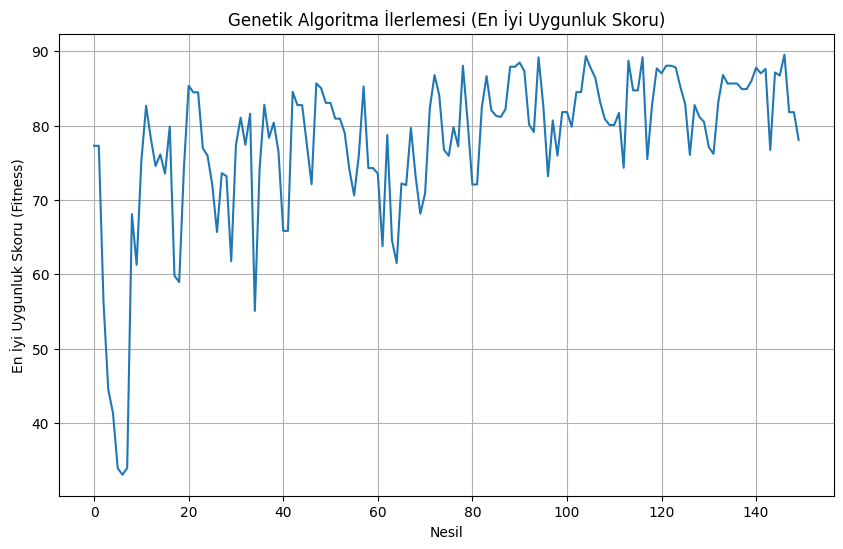

In [25]:
# GÖRSELLEŞTİRME
plt.figure(figsize=(10, 6))
plt.plot(uygunluk_gecmisi)
plt.title("Genetik Algoritma İlerlemesi (En İyi Uygunluk Skoru)")
plt.xlabel("Nesil")
plt.ylabel("En İyi Uygunluk Skoru (Fitness)")
plt.grid(True)
plt.show()